In [1]:
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List
import os 
import numpy as np 

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
csv_files = [f'../Finetuning/{count * 10}_labels.csv' for count in range(1, 6)]

In [4]:
def compute_rouge_l(candidate, reference):
    candidate = str(candidate)
    reference = str(reference) 
    m, n = len(candidate), len(reference)
    #print(m,n)
    dp_table = [[0] * (n + 1) for _ in range(m + 1)]
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if candidate[i - 1] == reference[j - 1]:
                dp_table[i][j] = dp_table[i - 1][j - 1] + 1
            else:
                dp_table[i][j] = max(dp_table[i - 1][j], dp_table[i][j - 1])
    
    return dp_table[m][n] / n

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katherinejijo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return filtered_tokens

In [7]:
def preprocess_text(text):
    # Tokenize the text
    text = str(text)
    tokens = word_tokenize(text.lower())
    
    return tokens

In [8]:
def compute_similarity_score(answer,syntheses):
    tokens_answer = preprocess_text(answer)
    tokens_syntheses = preprocess_text(syntheses)
    str_answer = ' '.join(tokens_answer)
    str_syntheses = ' '.join(tokens_syntheses)
    freqdist_answer = nltk.FreqDist(str_answer.split())
    freqdist_syntheses = nltk.FreqDist(str_syntheses.split())
    # Extract frequencies for unique tokens in both texts
    unique_tokens = set(freqdist_answer.keys()).union(freqdist_syntheses.keys())

    freq_answer = [freqdist_answer[token] for token in unique_tokens]
    freq_syntheses = [freqdist_syntheses[token] for token in unique_tokens]

    vector_answer = np.array(freq_answer).reshape(1, -1)
    vector_syntheses = np.array(freq_syntheses).reshape(1, -1)

    similarity_score = cosine_similarity(vector_answer, vector_syntheses)[0][0]

    return similarity_score

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

In [10]:
df_10 = pd.read_csv('../Finetuning/10_labels.csv',  index_col=0)
df_10

,Question,Refrence_Answer,Model_Response
0,What is the FY2018 capital expenditure amount ...,$1577.00,Based on the information provided in the 2018 ...
1,Assume that you are a public equities analyst....,$8.70,Based on the information provided in the balan...
2,Is 3M a capital-intensive business based on FY...,"No, the company is managing its CAPEX and Fixe...",Based on the information provided in the 10-K ...
3,What drove operating margin change as of FY202...,Operating Margin for 3M in FY2022 has decrease...,"According to the 10-K filing for 3M, the opera..."
4,"If we exclude the impact of M&A, which segment...",The consumer segment shrunk by 0.9% organically.,"According to 3M's 10-K filing for 2022, the se..."
...,...,...,...
145,Is Verizon a capital intensive business based ...,Yes. Verizon's capital intensity ratio was app...,"Yes, Verizon is a capital-intensive business b..."
146,Has Verizon increased its debt on balance shee...,No. Verizon's debt decreased by $229 million.,Based on the information provided in the 2022 ...
147,What is FY2018 days payable outstanding (DPO) ...,42.69,Based on the information provided in the Walma...
148,Based on the information provided primarily in...,0.2%,Based on the information provided in the state...


In [11]:
tokens_answer = preprocess_text(df_10['Refrence_Answer'][0])
tokens_syntheses = preprocess_text(df_10['Model_Response'][0])

In [12]:
tokens_answer

['$', '1577.00']

In [13]:
tokens_syntheses

['based',
 'on',
 'the',
 'information',
 'provided',
 'in',
 'the',
 '2018',
 '10-k',
 'document',
 ',',
 'the',
 'fy2018',
 'capital',
 'expenditure',
 'amount',
 'for',
 '3m',
 'is',
 '$',
 '1,577',
 'million',
 '.',
 'this',
 'amount',
 'can',
 'be',
 'found',
 'on',
 'the',
 'consolidated',
 'statement',
 'of',
 'cash',
 'flows',
 'under',
 'the',
 '``',
 'purchases',
 'of',
 'property',
 ',',
 'plant',
 'and',
 'equipment',
 '(',
 'pp',
 '&',
 'e',
 ')',
 "''",
 'section',
 '.']

In [15]:
num_labels = []
total_average_rouge_l_scores = []
total_average_cosine_similarity_scores = []

count = 0 
for csv_file in csv_files:
    count += 10
    num_labels.append(count)

    df = pd.read_csv(csv_file)
    rouge_l_scores = [] 
    cosine_similarity_scores = [] 

    for idx, row in df.iterrows():
        answer = row['Refrence_Answer']
        syntheses = row['Model_Response'] 

        compute_sim_score = compute_similarity_score(answer, syntheses)
        cosine_similarity_scores.append(compute_sim_score)

        rouge_l_score = compute_rouge_l(answer, syntheses)
        rouge_l_scores.append(rouge_l_score)

    total_average_cosine_similarity_score = sum(cosine_similarity_scores) / len(cosine_similarity_scores)
    total_average_cosine_similarity_scores.append(total_average_cosine_similarity_score)

    total_average_rouge_l_score = sum(rouge_l_scores) / len(rouge_l_scores)
    total_average_rouge_l_scores.append(total_average_rouge_l_score)

evaluation_summary_df = pd.DataFrame({
    'NumLabels': num_labels,
    'TotalAverageROUGE-L': total_average_rouge_l_scores,
    'TotalAverageCosineSimilarity': total_average_cosine_similarity_scores
})

evaluation_summary_df.to_csv('evaluation_summary.csv', index=False)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

Text(0.5, 1.0, ' After Fine-Tuning Cosine Similarity Score')

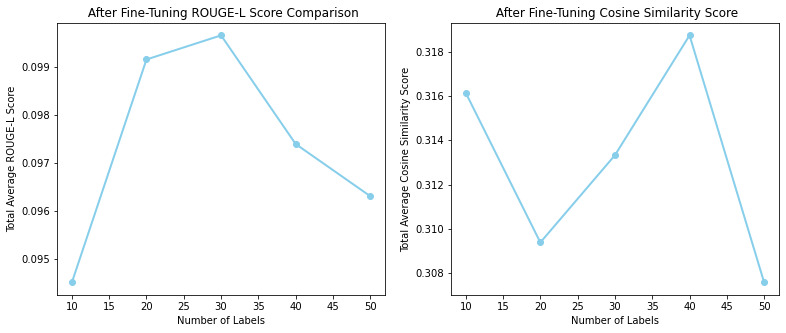

In [17]:

plt.figure(figsize=(20, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(num_labels, total_average_rouge_l_scores, marker='o', linestyle='-', color='skyblue', linewidth=2)

plt.xlabel('Number of Labels')
plt.ylabel('Total Average ROUGE-L Score')
plt.title(' After Fine-Tuning ROUGE-L Score Comparison')

plt.subplot(1, 3, 2)
plt.plot(num_labels, total_average_cosine_similarity_scores, marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Number of Labels')
plt.ylabel('Total Average Cosine Similarity Score')
plt.title(' After Fine-Tuning Cosine Similarity Score')